In [3]:
import numpy as np
import math
from scipy.special import erfc
from utils import bits_per_symbol
import pandas as pd
import matplotlib.pyplot as plt
import os
import scienceplots
from styles import set_plot_style

set_plot_style("prism_rain")
os.makedirs('figures', exist_ok=True)


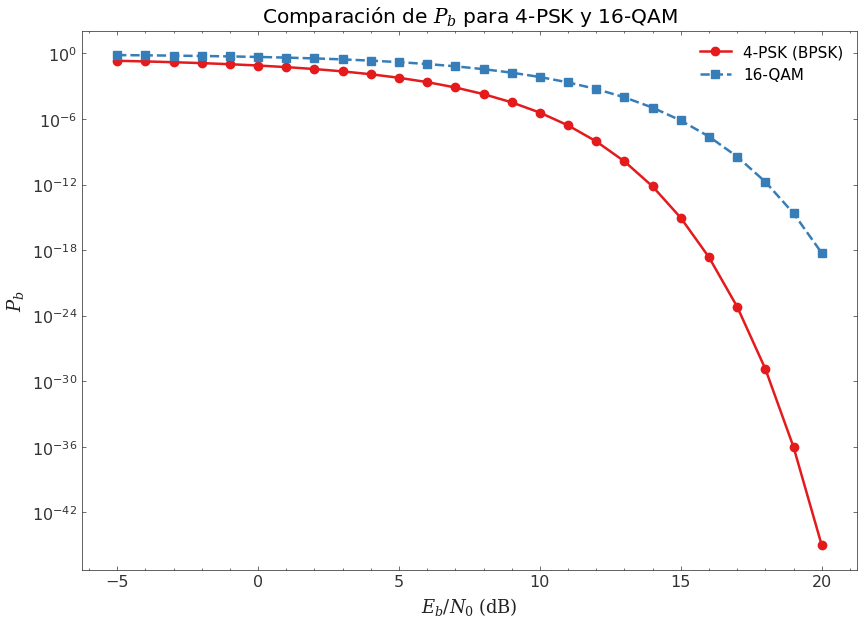

In [9]:
def Pb_4PSK(ebn0_lin):
    """
    P_{4PSK} = 1/2 * erfc(sqrt(Eb/N0))
    """
    return 0.5 * erfc(np.sqrt(ebn0_lin))

def Pb_16QAM(ebn0_lin):
    """
    P_{16QAM} = (3/2) * erfc( sqrt(2/5 * Eb/N0) )
                * [ 1 - (3/8) * erfc( sqrt(2/5 * Eb/N0) ) ]
    """
    x = np.sqrt((2/5) * ebn0_lin)
    return 1.5 * erfc(x) * (1 - 0.375 * erfc(x))

# Rango de Eb/N0 en dB
ebn0_db = np.arange(-5, 21, 1)           # 0 a 10 dB
ebn0_lin = 10**(ebn0_db/10.0)           # a escala lineal


# Cálculo de probabilidades de error
pb4 = Pb_4PSK(ebn0_lin)
p16 = Pb_16QAM(ebn0_lin)

# Impresión de resultados (cambiamos p16 ➔ p16_val en el for)
# print(" Eb/N0 (dB) |  P4PSK       |  P16QAM")
# print("---------------------------------------")
# for db, p4, p16_val in zip(ebn0_db, pb4, p16):
#     print(f"    {db:2d}     | {p4:.3e} | {p16_val:.3e}")

# Gráfico comparativo
plt.figure(figsize=(10,7))
plt.semilogy(ebn0_db, pb4,  'o-', label='4-PSK (BPSK)')
plt.semilogy(ebn0_db, p16,  's--', label='16-QAM')
plt.xlabel(r'$E_b/N_0\;\mathrm{(dB)}$')
plt.ylabel(r'$P_b$')
plt.title('Comparación de $P_b$ para 4-PSK y 16-QAM')
plt.legend()
plt.show()


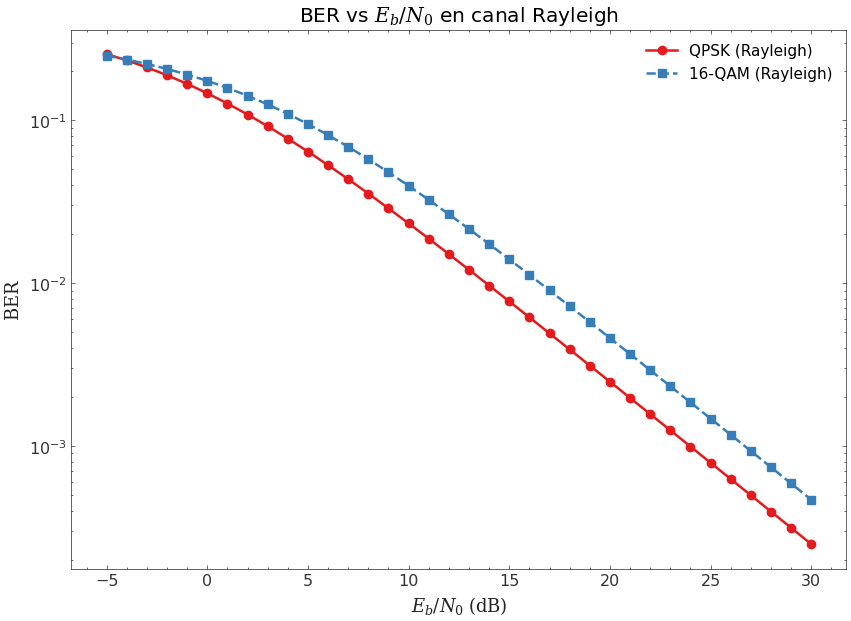

In [7]:
def ber_qpsk_rayleigh(ebn0_lin):
    """
    BER_QPSK(Rayleigh) = 1/2 * (1 - sqrt( (4*(Eb/N0)*sin^2(pi/4)) / (2 + 4*(Eb/N0)*sin^2(pi/4)) ))
    """
    sin2 = np.sin(np.pi/4)**2
    num = 4 * ebn0_lin * sin2
    den = 2 + num
    return 0.5 * (1 - np.sqrt(num/den))

def ber_16qam_rayleigh(ebn0_lin):
    """
    BER_16QAM(Rayleigh) = 3/8 * (1 - sqrt( (4*(Eb/N0)/5) / (2 + 4*(Eb/N0)/5) ))
    """
    num = 4 * ebn0_lin / 5
    den = 2 + num
    return 3/8 * (1 - np.sqrt(num/den))

# rango de Eb/N0 en dB
ebn0_db  = np.arange(-5, 31, 1)       # 0 a 10 dB
ebn0_lin = 10**(ebn0_db/10.0)       # a escala lineal

# calcular BER
ber_qpsk  = ber_qpsk_rayleigh(ebn0_lin)
ber_16qam = ber_16qam_rayleigh(ebn0_lin)

# graficar
plt.figure(figsize=(10,7))
plt.semilogy(ebn0_db, ber_qpsk,  'o-',  label='QPSK (Rayleigh)')
plt.semilogy(ebn0_db, ber_16qam, 's--', label='16-QAM (Rayleigh)')
plt.xlabel(r'$E_b/N_0\;(\mathrm{dB})$')
plt.ylabel(r'$\mathrm{BER}$')
plt.title('BER vs $E_b/N_0$ en canal Rayleigh')
plt.legend()
plt.show()


In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


modulations    = [4, 16]
pilot_spacings = [5, 10, 20]
channels       = ['awgn', 'rayleigh']
doppler_tags   = sorted(df.loc[df.channel=='doppler','scenario'].unique())
all_channels   = channels + doppler_tags

for M in modulations:
    B = int(math.log2(M))       # bits por símbolo
    for P in pilot_spacings:
        for channel in all_channels:
            # Filtrado por canal o escenario Doppler
            if channel in channels:
                df_s = df.query(
                    'modulation == @M and pilot_spacing == @P and channel == @channel'
                )
                label = channel
            else:
                df_s = df.query(
                    'modulation == @M and pilot_spacing == @P and scenario == @channel'
                )
                label = channel

            if df_s.empty:
                continue

            # Pivot: index=Es/N0 (dB), columnas=method, valores=BER
            ber_tbl = df_s.pivot_table(
                index='snr_db',
                columns='method',
                values='ber'
            ).sort_index()

            EsN0_db = ber_tbl.index.values
            EbN0_db = EsN0_db - 10*np.log10(B)   # conversión a Eb/N0

            plt.figure(figsize=(6,4))

            # 1) Simuladas vs Eb/N0
            for method in ['perfect','fft','cubic']:
                if method in ber_tbl.columns:
                    plt.semilogy(
                        EbN0_db,
                        ber_tbl[method].values,
                        marker='o',
                        label=f'{method.capitalize()} (sim)'
                    )

            # 2) Teóricas vs Eb/N0
            if channel == 'awgn':
                # teórica AWGN (usa Eb/N0 directamente)
                ebno_lin = 10**(EbN0_db/10)
                if M == 4:
                    # QPSK
                    theo = 0.5 *  erfc(np.sqrt(ebno_lin))
                else:
                    # M-QAM, union‐bound aproximado
                    alpha = 4*(1 - 1/np.sqrt(M)) / B
                    beta  = 3*B/(M-1)
                    theo  = alpha * 0.5 * erfc(np.sqrt(beta * ebno_lin))
                plt.semilogy(
                    EbN0_db, theo,
                    '--k', label='Teórico AWGN'
                )

            elif channel == 'rayleigh':
                # teórica Rayleigh
                ebno_lin = 10**(EbN0_db/10)
                if M == 4:
                    theo_ray = 0.5*(1 - np.sqrt(ebno_lin/(1+ebno_lin)))
                else:
                    theo_ray = [theoretical_ber_rayleigh(M, eb) for eb in EbN0_db]
                plt.semilogy(
                    EbN0_db, theo_ray,
                    '--k', label='Teórico Rayleigh'
                )

            plt.grid(which='both', ls=':')
            plt.xlabel('$E_b/N_0$ (dB)')
            plt.ylabel('Bit Error Rate')
            plt.title(f'M={M}, P={P}, canal={label}')
            plt.legend()
            plt.tight_layout()

            # Guardar
            outpath = os.path.join('figures',
                                   f'BER_{label}_P{P}_M{M}.pdf')
            plt.savefig(outpath)
            plt.close()
            print(f'→ escrito {outpath}')


→ escrito figures/BER_awgn_P5_M4.pdf
→ escrito figures/BER_rayleigh_P5_M4.pdf
→ escrito figures/BER_doppler_p40_v120_f3500MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p40_v120_f700MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p40_v30_f3500MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p40_v30_f700MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p5_v120_f3500MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p5_v120_f700MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p5_v30_f3500MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p5_v30_f700MHz_P5_M4.pdf
→ escrito figures/BER_awgn_P10_M4.pdf
→ escrito figures/BER_rayleigh_P10_M4.pdf
→ escrito figures/BER_doppler_p40_v120_f3500MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p40_v120_f700MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p40_v30_f3500MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p40_v30_f700MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p5_v120_f3500MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p5_v120_f700MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p5_v30_f3500M

In [5]:
from plots import plot_unequalized, plot_equalized

if __name__ == "__main__":
    # Parámetros globales
    modulations    = [4, 16]
    pilot_spacings = [5, 10, 20]
    snr_list       = [-5, 0, 10, 30]       # los 4 SNRs para las 2×2
    n_bits         = 100_000
    doppler_params = {
        'paths':       [5, 40],
        'speed_kmh':   [30, 120],
        'carrier_freq':[700e6, 3.5e9]
    }
    rng = np.random.default_rng(1234)

    for M in modulations:
        for P in pilot_spacings:
            # primero AWGN y Rayleigh (sin parámetros extra)
            for model in ['awgn', 'rayleigh']:
                print(f"=== M={M}, P={P}, canal={model} ===")
                plot_unequalized(
                    modulation_order=M,
                    model=model,
                    snr_list=snr_list,
                    n_bits=n_bits,
                    pilot_spacing=P,
                    rng=rng
                )
                plot_equalized(
                    modulation_order=M,
                    model=model,
                    snr_list=snr_list,
                    n_bits=n_bits,
                    pilot_spacing=P,
                    rng=rng
                )

            # ahora Doppler: barremos todas las combinaciones (paths, speed, freq)
            for paths in doppler_params['paths']:
                for speed in doppler_params['speed_kmh']:
                    for freq in doppler_params['carrier_freq']:
                        tag = f"doppler_p{paths}_v{speed}_f{int(freq/1e6)}MHz"
                        print(f"=== M={M}, P={P}, canal={tag} ===")
                        # en las funciones pasamos model='doppler' y les damos los parámetros
                        plot_unequalized(
                            modulation_order=M,
                            model='doppler',
                            snr_list=snr_list,
                            n_bits=n_bits,
                            pilot_spacing=P,
                            paths=paths,
                            speed_kmh=speed,
                            carrier_freq=freq,
                            rng=rng
                        )
                        plot_equalized(
                            modulation_order=M,
                            model='doppler',
                            snr_list=snr_list,
                            n_bits=n_bits,
                            pilot_spacing=P,
                            paths=paths,
                            speed_kmh=speed,
                            carrier_freq=freq,
                            rng=rng
                        )

=== M=4, P=5, canal=awgn ===
Saved unequalized plot to constellations/4_awgn_P5_unequalized.png
Saved equalized plot to constellations/4_awgn_P5_equalized.png
=== M=4, P=5, canal=rayleigh ===
Saved unequalized plot to constellations/4_rayleigh_P5_unequalized.png
Saved equalized plot to constellations/4_rayleigh_P5_equalized.png
=== M=4, P=5, canal=doppler_p5_v30_f700MHz ===
Saved unequalized plot to constellations/4_doppler_p5_v30kmh_f700MHz_P5_unequalized.png
Saved equalized plot to constellations/4_doppler_p5_v30kmh_f700MHz_P5_equalized.png
=== M=4, P=5, canal=doppler_p5_v30_f3500MHz ===
Saved unequalized plot to constellations/4_doppler_p5_v30kmh_f3500MHz_P5_unequalized.png
Saved equalized plot to constellations/4_doppler_p5_v30kmh_f3500MHz_P5_equalized.png
=== M=4, P=5, canal=doppler_p5_v120_f700MHz ===
Saved unequalized plot to constellations/4_doppler_p5_v120kmh_f700MHz_P5_unequalized.png
Saved equalized plot to constellations/4_doppler_p5_v120kmh_f700MHz_P5_equalized.png
=== M=4

/tmp/ipykernel_21345/893013776.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', M)


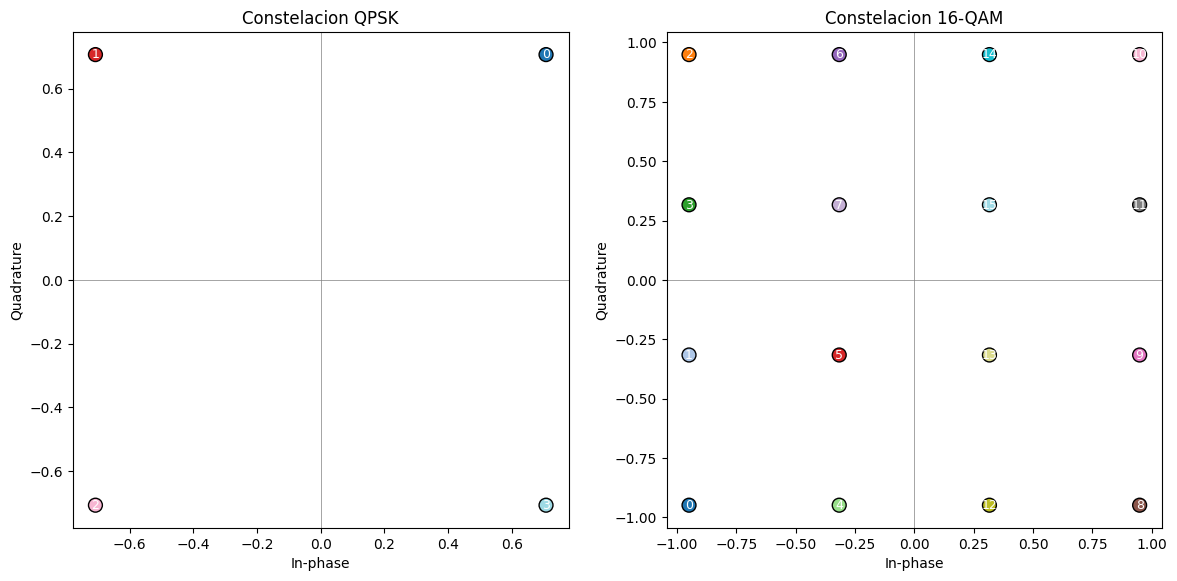

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from transmitter import modulate_sequence  # Asegúrate de que QPSK y QAM16 estén disponibles aquí

# Parámetros
mods   = [4, 16]
titles = ["Constelacion QPSK", "Constelacion 16-QAM"]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, M, title in zip(axes, mods, titles):
    # Índices de símbolo
    indices = np.arange(M)
    # Puntos de la constelación
    tx = modulate_sequence(indices, M)

    # Misma paleta que antes
    cmap = plt.cm.get_cmap('tab20', M)
    norm = mcolors.BoundaryNorm(np.arange(M+1)-0.5, M)
    
    # Dibujar
    ax.scatter(
        tx.real, tx.imag,
        c=indices, cmap=cmap, norm=norm,
        s=100, edgecolors='k'
    )
    ax.set_title(title)
    ax.set_xlabel("In‐phase")
    ax.set_ylabel("Quadrature")
    ax.axhline(0, color='gray', lw=0.5)
    ax.axvline(0, color='gray', lw=0.5)
    ax.set_aspect('equal', 'box')
    # Etiquetar cada punto con su índice
    for idx, point in zip(indices, tx):
        ax.text(
            point.real, point.imag, str(idx),
            ha='center', va='center',
            fontsize=9, color='white'
        )

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


/tmp/ipykernel_21345/3366851913.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', M)


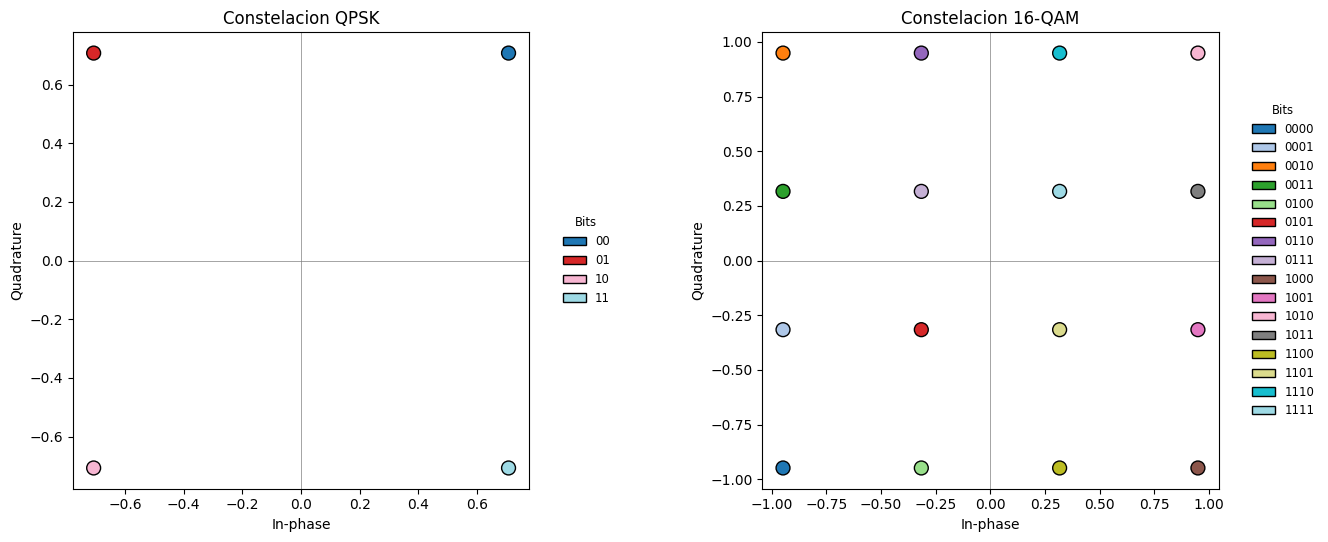

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from transmitter import modulate_sequence  # Aquí importa tu función de modulador

mods   = [4, 16]
titles = ["Constelacion QPSK", "Constelacion 16-QAM"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, M, title in zip(axes, mods, titles):
    indices = np.arange(M)
    bps = int(np.log2(M))
    tx = modulate_sequence(indices, M)

    cmap = plt.cm.get_cmap('tab20', M)
    norm = mcolors.BoundaryNorm(np.arange(M+1)-0.5, M)
    
    ax.scatter(tx.real, tx.imag, c=indices, cmap=cmap, norm=norm,
               s=100, edgecolors='k')
    ax.set_title(title)
    ax.set_xlabel("In‐phase")
    ax.set_ylabel("Quadrature")
    ax.axhline(0, color='gray', lw=0.5)
    ax.axvline(0, color='gray', lw=0.5)
    ax.set_aspect('equal', 'box')

    # Construir leyenda: parches coloreados con la cadena de bits
    handles = []
    for idx in indices:
        color = cmap(norm(idx))
        bitstr = format(idx, f'0{bps}b')
        patch = mpatches.Circle((0,0), radius=0.1, facecolor=color,
                                edgecolor='k', label=bitstr)
        handles.append(patch)

    ax.legend(handles=handles, title="Bits",
              loc='center left', bbox_to_anchor=(1.05, 0.5),
              frameon=False, fontsize='small', title_fontsize='small')

#plt.suptitle("Constelaciones de bits pre-transmision", fontsize=16)
plt.savefig("bits_transmitidos.png", dpi = 200)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [11]:
# ——— Funciones teóricas ———
def Pb_4PSK(ebn0_lin):
    """P_{4PSK} = 1/2 * erfc(sqrt(Eb/N0))"""
    return 0.5 * erfc(np.sqrt(ebn0_lin))

def Pb_16QAM(ebn0_lin):
    """
    P_{16QAM} = (3/2) * erfc( sqrt(2/5 * Eb/N0) )
                * [ 1 - (3/8) * erfc( sqrt(2/5 * Eb/N0) ) ]
    """
    x = np.sqrt((2/5) * ebn0_lin)
    return 1.5 * erfc(x) * (1 - 0.375 * erfc(x))

def ber_qpsk_rayleigh(ebn0_lin):
    """
    BER_QPSK(Rayleigh) = 1/2 * (1 - sqrt( (4*(Eb/N0)*sin^2(pi/4)) / (2 + 4*(Eb/N0)*sin^2(pi/4)) ))
    """
    sin2 = np.sin(np.pi/4)**2
    num = 4 * ebn0_lin * sin2
    den = 2 + num
    return 0.5 * (1 - np.sqrt(num/den))

def ber_16qam_rayleigh(ebn0_lin):
    """
    BER_16QAM(Rayleigh) = 3/8 * (1 - sqrt( (4*(Eb/N0)/5) / (2 + 4*(Eb/N0)/5) ))
    """
    num = 4 * ebn0_lin / 5
    den = 2 + num
    return 3/8 * (1 - np.sqrt(num/den))



df = pd.read_csv('BER_sweep_results_2.csv')

# ——— Parámetros de simulación ———
modulations    = [4, 16]
pilot_spacings = [5, 10, 20]
channels       = ['awgn', 'rayleigh']
doppler_tags   = sorted(df.loc[df.channel=='doppler','scenario'].unique())
all_channels   = channels + doppler_tags


for M in modulations:
    B = int(math.log2(M))  # bits por símbolo

    for P in pilot_spacings:
        for channel in all_channels:

            # Filtrado de datos simulados
            if channel in channels:
                df_s = df.query(
                    'modulation == @M and pilot_spacing == @P and channel == @channel'
                )
                label = channel
            else:
                df_s = df.query(
                    'modulation == @M and pilot_spacing == @P and scenario == @channel'
                )
                label = channel

            if df_s.empty:
                continue

            # Pivot table: index=Es/N0 (dB), columns=method, values=ber
            ber_tbl = (
                df_s
                .pivot_table(index='snr_db', columns='method', values='ber')
                .sort_index()
            )

            EbN0_db = ber_tbl.index.values
            EbN0_lin = 10**(EbN0_db/10.0)

            plt.figure(figsize=(10,7))

            # 1) Curvas simuladas
            for method in ['perfect', 'fft', 'cubic']:
                if method in ber_tbl.columns:
                    plt.semilogy(
                        EbN0_db,
                        ber_tbl[method].values,
                        marker='o',
                        label=f'{method.capitalize()} (sim)'
                    )

            # 2) Curvas teóricas
            if channel == 'awgn':
                if M == 4:
                    theo = Pb_4PSK(EbN0_lin)
                else:
                    theo = Pb_16QAM(EbN0_lin)
                label_theo = 'Teórico AWGN'
                plt.semilogy(EbN0_db, theo, '--k', label=label_theo)
            elif channel == 'rayleigh':
                if M == 4:
                    theo = ber_qpsk_rayleigh(EbN0_lin)
                else:
                    theo = ber_16qam_rayleigh(EbN0_lin)
                label_theo = 'Teórico Rayleigh'
                plt.semilogy(EbN0_db, theo, '--k', label=label_theo)

            # Formato del gráfico
            plt.grid(True, which='both', ls=':')
            plt.xlabel('$E_b/N_0$ (dB)')
            plt.ylabel('Bit Error Rate')
            plt.title(f'M={M}, P={P}, canal={label}')
            plt.legend()
            plt.tight_layout()

            # Guardar figura
            outpath = os.path.join('figures', f'BER_{label}_P{P}_M{M}.pdf')
            plt.savefig(outpath)
            plt.close()
            print(f'→ escrito {outpath}')

→ escrito figures/BER_awgn_P5_M4.pdf
→ escrito figures/BER_rayleigh_P5_M4.pdf
→ escrito figures/BER_doppler_p40_v120_f3500MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p40_v120_f700MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p40_v30_f3500MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p40_v30_f700MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p5_v120_f3500MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p5_v120_f700MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p5_v30_f3500MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p5_v30_f700MHz_P5_M4.pdf
→ escrito figures/BER_awgn_P10_M4.pdf
→ escrito figures/BER_rayleigh_P10_M4.pdf
→ escrito figures/BER_doppler_p40_v120_f3500MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p40_v120_f700MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p40_v30_f3500MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p40_v30_f700MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p5_v120_f3500MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p5_v120_f700MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p5_v30_f3500M

In [9]:

# ——— Parámetros de simulación ———
df = pd.read_csv('BER_sweep_results_2.csv')
modulations    = [4, 16]
pilot_spacings = [5, 10, 20]
paths_list     = [5, 40]
speeds_kmh     = [30, 120]
freqs_hz       = [700e6, 3.5e9]

for M in modulations:
    B = int(math.log2(M))

    # Creamos figura con 2 filas x 3 columnas
    fig, axes = plt.subplots(3, 2, figsize=(11, 17), sharex=True, sharey=True)
    axes = axes.flatten()

    # Recorremos los 6 combos (P, paths)
    for idx, (P, L) in enumerate([(P, L) for P in pilot_spacings for L in paths_list]):
        ax = axes[idx]
        # Por cada (velocidad, frecuencia) trazamos la curva simulada
        for v in speeds_kmh:
            for fc in freqs_hz:
                scenario = f"doppler_p{L}_v{v}_f{int(fc/1e6)}MHz"
                df_s = df.query(
                    'modulation == @M and pilot_spacing == @P and scenario == @scenario'
                )
                if df_s.empty:
                    continue

                # Extraemos Es/N0 (dB) y convertimos a Eb/N0 si hace falta
                EsN0_db = np.sort(df_s['snr_db'].unique())
                EbN0_db = EsN0_db - 10*np.log10(B)

                # Pivot para obtener BER simulada (aquí usamos 'perfect')
                ber_tbl = (
                    df_s
                    .pivot_table(index='snr_db', columns='method', values='ber')
                    .sort_index()
                )
                sim_ber = ber_tbl['perfect'].values

                label = f"v={v} km/h, f={int(fc/1e6)} MHz"
                ax.semilogy(EbN0_db, sim_ber, '-o', label=label)

        # Formato de cada subplot
        ax.grid(True, which='both', ls=':')
        ax.set_title(f"P={P}, paths={L}")
        if idx % 3 == 0:
            ax.set_ylabel('BER')
        if idx >= 3:
            ax.set_xlabel(r'$E_b/N_0$ (dB)')
        ax.legend(fontsize='small')

    fig.suptitle(f"BER Doppler — M = {M} ({'QPSK' if M==4 else '16-QAM'})", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    outpath = f"figures/BER_doppler_M{M}.pdf"
    fig.savefig(outpath)
    plt.close(fig)
    print(f"→ escrito {outpath}")


→ escrito figures/BER_doppler_M4.pdf
→ escrito figures/BER_doppler_M16.pdf
